### You can run this notebook at Colab by clicking here:

<a target="_blank" href="https://colab.research.google.com/github/comcon1/databank-template/blob/monolayer-dev/ml-scripts/ml-correction-notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Monolayer isotherm correction

**Authors:** 
- Fabián Suárez Lestón (Universidade de Santiago de Compostela)  
  [email:fabian.suarez.leston@usc.es]
- Alexey M. Nesterenko (University of Bergen, Computational Biology Unit)  
  [email:comcon1@protonmail.com]
- Markus S. Miettinen (University of Bergen, Computational Biology Unit)  
  [email:markus.miettinen@uib.no]

**Requirements:**

1. Folder `./Databank-monolayers` should be initialized by *NMRlipids/Databank@monolayer-dev* from one of the sources
    - https://github.com/fsuarezleston/NMRLipids_Databank/tree/monolayer-dev
    - https://github.com/comcon1/Databank/tree/monolayer-dev
2. Please make your python environment to satisfy NMRLipids Databank requirements. We don't have any additional requirements inside this notebook.

In [1]:
# This installs NMRlipids Databank on COLAB environment,
# you can use the same commands on your local machine if you run it locally.

import sys

if 'google.colab' in sys.modules:
    !pip install MDAnalysis pyyaml
    %cd /content
    !git clone https://github.com/fsuarezleston/NMRLipids_Databank ./Databank-monolayers
    %cd Databank-monolayers
    !git checkout monolayer-dev
    %cd ..

In [1]:
import os
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Add NMRlipids Databank libraries (monolayer fork)  into the system path. And then import what we need now!
DBPath =  './Databank-monolayers/'
_ = os.path.join(DBPath, 'Scripts/BuildDatabank/')
if not os.path.isdir(_):
    raise FileNotFoundError(_)
sys.path.insert(1, _)

# finally, importing
from databankLibrary import ( initialize_databank, getBatch, getpA_isotherm, calcXRR, calcArea )

## Load data from the Databank

In [3]:
# initialize the databank and load batch with DPPC
systems = initialize_databank(DBPath)
# get the batch of DPPC simulations from Matti Javanaianen
batch = getBatch( "MJ_DPPC_10.1021/acs.langmuir.7b02855", systems=systems )

Databank initialized from the folder: /big/comcon1/repo/Databank-monolayers/Data/Simulations


In [4]:
# extract area array and sort batch by area
area = [ calcArea(s)/256 for s in batch ]
sidx = np.argsort(area)
area = np.sort(area)
batch = [batch[i] for i in sidx]

512 44.999698638916016
512 56.965599060058594
512 78.29263305664062
512 53.7432861328125
512 110.15735626220703
512 65.79420471191406
512 86.15250396728516
512 63.01084899902344
512 102.12063598632812
512 94.38656616210938
512 47.99960708618164
512 60.288726806640625
512 75.25475311279297
512 51.231597900390625
512 72.27507019042969
512 68.63407897949219


In [5]:
# Load pA isotherm from batch
ap = pd.DataFrame(
    getpA_isotherm(batch), 
    columns=['ApL', 'ST', 'STdev'])
pW = 70.104 # mN/m (OPC4 surf.tens)
ap.eval(f'p = {pW} - ST', inplace=True)
ap.head()

,ApL,ST,STdev,p
0,44.999699,4.961681,0.297478,65.142319
1,47.999607,12.394999,0.277196,57.709001
2,51.231598,30.429852,0.259110,39.674148
3,53.743286,44.289235,0.245561,25.814765
4,56.965599,53.568450,0.231604,16.535550


In [6]:
# Read corresponding experimental pA isotherm
refd = pd.read_csv( "./Databank-monolayers/Data/experiments/Isotherms/10.1016/j.bbamem.2016.09.015/1/DPPC_isotherm_Olzynska2016.csv", 
                   header=None, skiprows=1)
refd.head()

,0,1
0,39.092971,50.237467
1,41.451247,46.015831
2,42.721088,41.794195
3,44.172336,37.572559
4,45.623583,33.350923


## Plot exp. isotherm before correction vs MD isotherm

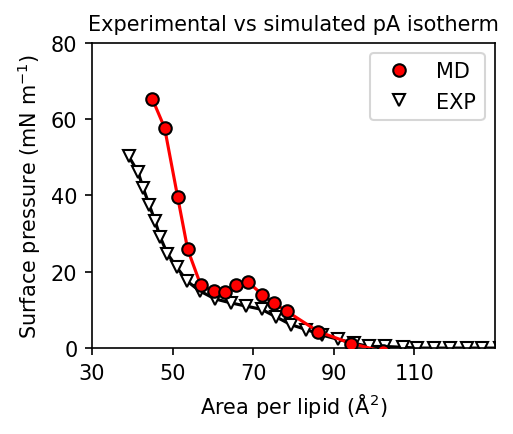

In [7]:
# Plot the isotherm before the correction
fig, ax = plt.subplots( figsize=(3.5,3.0), tight_layout=True, dpi=150 )

# Plot MD isotherm
ax.plot( ap.ApL, ap.p, "o", mec="k", color='r', label="MD", zorder=20 ) # ~13.6 Å^2 difference 
ax.errorbar( ap.ApL, ap.p, yerr=ap.STdev, color='r', zorder=19 )

# Plot EXP isotherm
ax.plot( refd[0], refd[1], "k-" )
ax.plot( refd[0], refd[1], "wv", mec='k', label="EXP" )

ax.legend()
ax.set_ylabel( r"Surface pressure (mN m$^{-1}$)")
ax.set_xlabel( r"Area per lipid (Å$^{2}$)")
ax.set_ylim(0,80)
ax.set_xlim(30,130)
ax.set_xticks(np.arange(30,130,20))
ax.set_title('Experimental vs simulated pA isotherm', fontsize=10)
plt.show()

## Experimental and Simulated X-Ray reflectometry data

In [8]:
with open('./Databank-monolayers/Data/experiments/XRR/10.1007/s00249-006-0119-x/2/README.yaml', 'r') as fd:
    readme = yaml.safe_load(fd, )
ExpSP = readme['SURFACE_PRESSURE']
print(f'XRR is recorded at {ExpSP} mN/m')

XRR is recorded at 40 mN/m


In [9]:
# Load XRR Data from 10.1007/s00249-006-0119-x
ExpXRR = pd.read_csv( f"./Databank-monolayers/Data/experiments/XRR/10.1007/s00249-006-0119-x/2/DPPC_XRR_40mNm.csv", skiprows=1, header=None )
ExpXRR.columns = ['Qz/Qc', 'R/Rf']
ExpXRR.head()

,Qz/Qc,R/Rf
0,0.870076,0.730284
1,1.253483,1.132318
2,1.960790,1.349456
3,2.990977,1.430723
4,4.472254,1.473174


In [10]:
# The critical wavelength (to match the experimental data). See 10.1021/j100345a063 for experimental details.
wl = 1.38
# The critical wavevector transfer (to match the experimental data)
qc = 4*np.pi/wl*np.sin(0.13*np.pi/180)

# Compute pure Qz values 
ExpXRR.eval(f'Qz = `Qz/Qc`*{qc}', inplace=True)

ExpXRR.head()

,Qz/Qc,R/Rf,Qz
0,0.870076,0.730284,0.017977
1,1.253483,1.132318,0.025898
2,1.960790,1.349456,0.040512
3,2.990977,1.430723,0.061797
4,4.472254,1.473174,0.092401


In [11]:
# generating simulated set of XRR data for every simulated system
# .. computed at the same Qz points as experimental data
XRRData = []
for s in batch:
    # Read the simulation data
    with open(os.path.join(DBPath, 'Data/Simulations', s['path'], "edens.json"), "r") as fd:
        SimEDens = json.load(fd)
    sed = pd.DataFrame(SimEDens).T.reset_index()
    del(SimEDens)
    sed.columns = ['z', 'p1', 'p2', 'p3'] # p1-3 edens of different subsystems
    sed.eval('ed = p1+p2+p3', inplace=True)
    # Get the simulated XRR profile in the same points as the experiment
    xrd = calcXRR(sed.ed, sed.z, ExpXRR.Qz, w_dens=sed.ed.iloc[-1], wl=wl, norm=True)
    XRRData.append(xrd)

# The resulting XRRData is a list of curves. Every curve is just R/Rf values, 
# because Qz values are all the same: ExpXRR.Qz

In [12]:
# set-up proper coloring for 16 curves because we will show 16 XRR curves
import matplotlib.cm as cm
colors = [cm.rainbow(i/len(batch)) for i in range(len(batch))]
plt.rc('axes', prop_cycle=plt.cycler(color=colors))

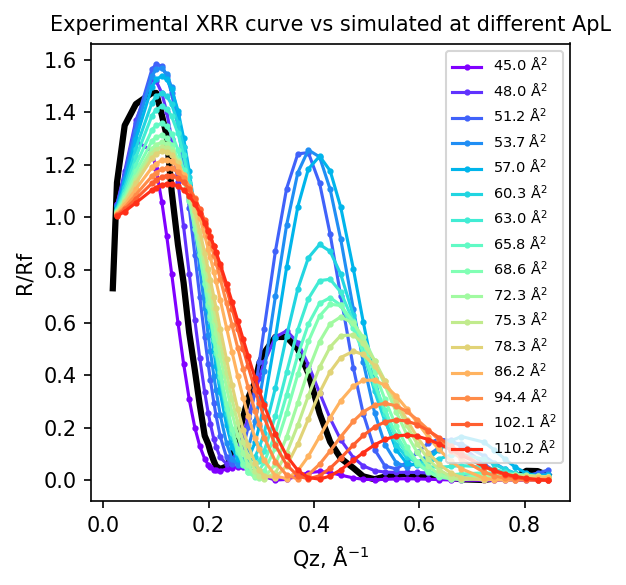

In [13]:
# Plot XRR data
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True, dpi=150)
ax.plot(ExpXRR.Qz, ExpXRR['R/Rf'], '-k', lw=3)
for i in range(len(batch)):
    ax.plot(ExpXRR.Qz, XRRData[i], '.-', label='%.1f Å$^2$' % area[i], ms=4)
ax.legend(fontsize=7)
ax.set_ylabel('R/Rf')
ax.set_xlabel('Qz, Å$^{-1}$')
ax.set_title('Experimental XRR curve vs simulated at different ApL', fontsize=10)
plt.show()

## Finding the best match

In [14]:
# Function defining the best match. It compares many XRR curves to one experimental
# and finds the best matching one. Since the right part of experimental curves has
# a large noise, we use only some Qz range for the comparison. This range is set by slice
# (see the line before usage example).
def BestMatch(Reference, Guesses, cmpIdx=slice(None)):
    Differences = []
    _ref = Reference[cmpIdx]
    for Guess in Guesses:
        _gues = Guess[cmpIdx]
        Differences.append( np.mean( (np.log10(_ref)-np.log10(_gues))**2 )**0.5 )
    return np.argmin(Differences), Differences

# The system which best matches the experimental data
cmpIdx = ExpXRR.query('Qz <= 0.6 and Qz > 0.02').index
Best, Differences = BestMatch(ExpXRR['R/Rf'], XRRData, cmpIdx)
print(f"The best curve is system #{Best} with ApL = {ap.ApL.loc[Best]} Å2")

The best curve is system #1 with ApL = 47.99960708618164 Å2


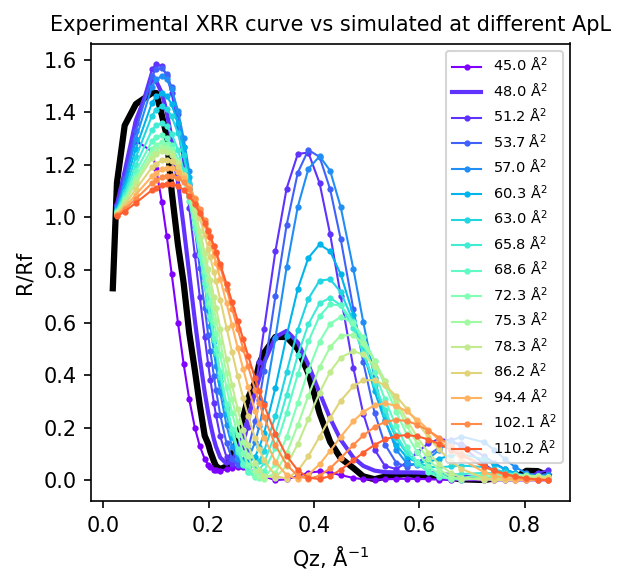

In [15]:
# Plot XRR data, but highlighting the best one!
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True, dpi=150)

ax.plot(ExpXRR.Qz, ExpXRR['R/Rf'], '-k', lw=3)
for i in range(len(batch)):
    if i == Best:
        ax.plot(ExpXRR.Qz, XRRData[Best], '-', color=colors[Best], lw=2, label='%.1f Å$^2$' % area[i])
    else:
        ax.plot(ExpXRR.Qz, XRRData[i], '.-', label='%.1f Å$^2$' % area[i], ms=4, lw=1)

ax.legend(fontsize=7)
ax.set_ylabel('R/Rf')
ax.set_xlabel('Qz, Å$^{-1}$')
ax.set_title('Experimental XRR curve vs simulated at different ApL', fontsize=10)
plt.show()

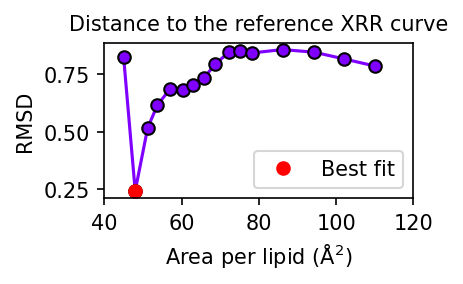

In [16]:
# figure representing the distance from many XRR curves to the reference one
fig, ax = plt.subplots( figsize=(3,2), tight_layout=True, dpi=150 )
ax.plot( ap.ApL, Differences, "o-", mec="k")
ax.plot( ap.ApL[ Best ], Differences[ Best ], "ro", label = "Best fit" )
ax.set_ylabel("RMSD")
ax.set_xlabel("Area per lipid (Å$^2$)")
ax.set_xlim(40,120)
ax.legend()
ax.set_title('Distance to the reference XRR curve', fontsize=10)
plt.show()

## Making the correction!

In [17]:
# function for simple interpolation
def FindPoint( df, Value ):
    X1, Y1 = df[df[1]>Value].iloc[-1]
    X2, Y2 = df[df[1]<Value].iloc[0]
    return X1 + ( Value - Y1 ) * ( X2 - X1 ) / ( Y2 - Y1 ) 

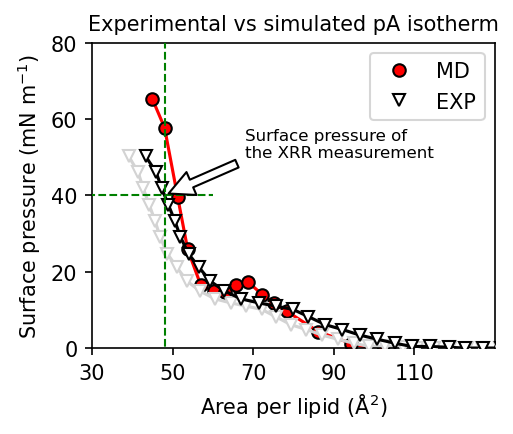

In [19]:
# Plot the isotherm before the correction
fig, ax = plt.subplots( figsize=(3.5,3.0), tight_layout=True, dpi=150 )

# Plot MD isotherm
ax.plot( ap.ApL, ap.p, "o", mec="k", color='r', label="MD", zorder=1 ) # ~13.6 Å^2 difference 
ax.errorbar( ap.ApL, ap.p, yerr=ap.STdev, color='r', zorder=0 )

#refd = pd.read_csv( "./DPPC_isotherm_Olzynska2016.csv", header=None, skiprows=1 )
ax.plot( refd[0], refd[1], "-", color="lightgray",zorder=2 )
ax.plot( refd[0], refd[1], "wv", mec='lightgray',zorder=3 )

# Now we apply the correction. It is applied ONLY to X values of (X,Y) curve
newA = ap.ApL[Best]/FindPoint(refd,ExpSP)*refd[0]
ax.plot( newA, refd[1], "k-",zorder=4 )
ax.plot( newA, refd[1], "wv", mec='k', label=r"EXP",zorder=5 )

ax.legend()
ax.set_ylabel( r"Surface pressure (mN m$^{-1}$)")
ax.set_xlabel( r"Area per lipid (Å$^{2}$)")
ax.set_ylim(0,80)
ax.set_xlim(30,130)
ax.set_xticks(np.arange(30,130,20))
ax.set_title('Experimental vs simulated pA isotherm', fontsize=10)

ax.vlines(ap.ApL[Best], ymin=-200, ymax=200, colors='green', linestyles='dashed', linewidth=1, zorder=15)
ax.hlines(ExpSP, xmin=-200, xmax=60, colors='green', linestyles='dashed', linewidth=1, zorder=15)
ax.annotate( "Surface pressure of \nthe XRR measurement", 
               xy=(ap.ApL[ Best ], 40), 
               xytext=(ap.ApL[ Best ] + 20, 40 + 10), 
               arrowprops=dict(facecolor="w", edgecolor="k", shrink=0.05), 
               zorder=16, 
               fontfamily='sans-serif',
               fontsize=8)

plt.show()

